In [2]:
from IPython.display import Image, display

import graphviz
from typing import Literal
import random
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Optional
from openai import OpenAI,AsyncOpenAI
from dotenv import load_dotenv
import uuid
import asyncio

load_dotenv()

True

![framework](./resources/stand-alone%20multi%20agent%20framework_v2.png)

### Async Version

In [3]:
class Agent:
    def chat(self, message: list|str, **kwargs) -> str:
        """
        Synchronous chat method. Can be overridden by subclasses.
        """
        return f"Agent received: {message}"

    async def chat_async(self, message: list|str, **kwargs) -> str:
        """
        Asynchronous chat method. Can be overridden by subclasses.
        """
        await asyncio.sleep(1)  # Simulate async operation
        return f"Agent received asynchronously: {message}"

In [4]:
class iAgent(Agent):
    """
    simple demo
    """
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.async_client = AsyncOpenAI()
        self.client = OpenAI()


    def chat(self, messages: list|str,stream: bool = False):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
                stream=stream
            )
        
        if not stream:
            return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]
        else:
            streamed_response = ""

            for chunk in response:
                try:
                    chunk_content = chunk.choices[0].delta.content
                    print(chunk_content or "", end="")
                    if chunk_content is not None:
                        streamed_response = streamed_response + chunk_content
                except:
                    pass
            return {"role": "assistant", "content": streamed_response,"sender": self.name}

    async def chat_async(self, messages: list|str,stream: bool = False):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = await self.async_client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
                stream=stream
            )
        
        if not stream:
            return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]
        else:
            streamed_response = ""

            async for chunk in response:
                try:
                    chunk_content = chunk.choices[0].delta.content
                    print(chunk_content or "", end="")
                    if chunk_content is not None:
                        streamed_response = streamed_response + chunk_content
                except:
                    pass
            return {"role": "assistant", "content": streamed_response,"sender": self.name}

In [5]:
example_agent = iAgent("example","You are a helpful assistant")
res1 = example_agent.chat("Hello, Who are you?")
res2 = await example_agent.chat_async("Hello, Who are you?")

print(res1)
print(res2)

[{'role': 'assistant', 'content': "Hello! I'm an AI assistant here to help you with a variety of questions and tasks. Whether you need information, support, or advice, feel free to ask!", 'sender': 'example'}]
[{'role': 'assistant', 'content': 'Hello! I’m an AI language model here to help you with a variety of topics, answer questions, or engage in conversation. How can I assist you today?', 'sender': 'example'}]


In [6]:
@dataclass
class AgentSchema:
    """
    This class defines the schema of the agent used for the handoff process.
    """
    name: str
    transfer_to_me_description: str
    agent: Agent
    relations: Optional[List[str]] = None # agent names that this agent can transfer to
    as_entry: bool = False  # Default to False
    as_exit: bool = False   # Default to False

In [17]:
class Group:
    def __init__(self, 
                 participants: list[AgentSchema], 
                 model_client: OpenAI = AsyncOpenAI()):
        """ 
        Initializes the group with the given participants and model client.

        Args:
            participants (list[AgentSchema]): A list of AgentSchema objects representing the participants in the group.
            model_client (OpenAI, optional): The OpenAI client used for the handoff process. Defaults to OpenAI().

        Raises:
            ValueError: If the group structure is not valid.
        """
        self.participants = participants
        self.model_client = model_client
        self.entry_agent = next((p for p in participants if p.as_entry), random.choice(participants))
        self.current_agent = {"DEFAULT":self.entry_agent}
        self.exit_agent = next((p for p in participants if p.as_exit), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = {"DEFAULT":[]}
        self.participants_order_map = self._build_participant_order_map()
        self.group_structure = self._decide_group_structure()

    def reset(self,
              thread_id:Optional[str] = None):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.entry_agent = next((p for p in self.participants if p.as_entry), random.choice(self.participants))
        if thread_id:
            self.current_agent[thread_id] = self.entry_agent
            self.handoff_tools[thread_id] = []
        else:
            self.current_agent = {"DEFAULT":self.entry_agent}
            self.handoff_tools = {"DEFAULT":[]}

    async def handoff_one_turn(self, 
                         messages: list|str,
                         model:str="gpt-4o-mini",
                         next_speaker_select_mode:Literal["order","auto","random"]="auto",
                         include_current:bool = True,
                         thread_id: str = "DEFAULT",
                         verbose=False
                         ):
        """ 
        Performs a single turn of the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to "DEFAULT".
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        if next_speaker_select_mode == "order":
            if self.group_structure != "CONNECTED":
                raise ValueError("next_speaker_select_mode 'order' is only supported when group_structure is 'CONNECTED'")
            next_agent = self.participants_order_map[self.current_agent.get(thread_id,self.entry_agent).name]
            if verbose:
                current_agent = self.current_agent.get(thread_id,self.entry_agent).name
                print(f"\n-> handoff from {current_agent} to {next_agent} (order mode)")
            self.current_agent[thread_id] = self.agent_map[next_agent]
            return next_agent
        
        elif next_speaker_select_mode == "random":
            next_agent = random.choice(self.agent_names)
            if verbose:
                current_agent = self.current_agent.get(thread_id,self.entry_agent).name
                print(f"\n-> handoff from {current_agent} to {next_agent} (random mode)")
            self.current_agent[thread_id] = self.agent_map[next_agent]
            return next_agent
 
        elif next_speaker_select_mode == "auto":
            
            self._build_current_handoff_tools(include_current=include_current,thread_id=thread_id)
    
            if isinstance(messages, str):
                messages = [{"role": "user", "content": messages}]
            messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

            response = await self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=self.handoff_tools.get(thread_id,[]),
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name

            if next_agent in self.agent_names:
                if self.current_agent.get(thread_id,self.entry_agent).name != next_agent and verbose:
                    print("\n-> handoff from {} to {} (auto mode)".format(self.current_agent.get(thread_id,self.entry_agent).name, next_agent))
                self.current_agent[thread_id] = self.agent_map[next_agent]
            else:
                raise ValueError(f"Handoff to unknown agent: {next_agent}")

            return next_agent
    
        else:
            raise ValueError(f"Unknown next_speaker_select_mode: {next_speaker_select_mode} , Currently only 'order', 'random' and 'auto' are supported")

    async def handoff(self, 
                messages: list|str,
                model:str="gpt-4o-mini",
                handoff_max_turns:int=10,
                next_speaker_select_mode:Literal["order","auto","random"]="auto",
                include_current = True,
                thread_id: str = "DEFAULT",
                verbose=False
                ):

        """ 
        Performs the handoff process.

        Args:
            messages (list|str): The messages to be used for the handoff process.
            model (str, optional): The model used for the handoff process. Defaults to "gpt-4o-mini".
            handoff_max_turns (int, optional): The maximum number of turns to perform the handoff process. used in auto mode. Defaults to 10.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to "DEFAULT".
            verbose (bool, optional): Whether to print the handoff process. Defaults to False.
        """

        next_agent = await self.handoff_one_turn(messages,model,next_speaker_select_mode,include_current,thread_id,verbose)
        if next_speaker_select_mode != "auto" or handoff_max_turns == 1:
            return next_agent
        next_next_agent = await self.handoff_one_turn(messages,model,"auto",include_current,thread_id,verbose)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = await self.handoff_one_turn(messages,model,"auto",include_current,thread_id,verbose)
            handoff_max_turns -= 1
        return next_agent


    async def chat(self, 
             messages: list|str,
             model:str="gpt-4o-mini",
             next_speaker_select_mode:Literal["auto","random"]="auto",
             entry_agent:str=None,
             thread_id: str = None,
             verbose=False
             ):
        
        """ 
        Performs a chat conversation with the group.

        Args:
            messages (list|str): The messages to be used for the chat conversation.
            model (str, optional): The model used for the chat conversation. Defaults to "gpt-4o-mini".
            next_speaker_select_mode (Literal["auto","random"], optional): The mode used to select the next speaker. Defaults to "auto".
            entry_agent (str, optional): The name of the agent to start the conversation. Defaults to None. You can set it to overwirte the current agent
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the chat conversation. Defaults to False.

        Returns:
            list: A list of messages exchanged during the chat conversation.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure not in ["CONNECTED","CUSTOM"]:
            raise ValueError("chat is only supported when group_structure is 'CONNECTED' or 'CUSTOM'")

        if entry_agent and entry_agent in self.agent_names:
            self.current_agent[thread_id] = self.agent_map[entry_agent]
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        next_agent = await self.handoff(messages,model,10,next_speaker_select_mode,True,thread_id,verbose)

        response = await self.agent_map[next_agent].agent.chat_async(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")

        return response


    async def task(self,
             task:str,
             model:str="gpt-4o-mini",
             thread_id: Optional[str] = None,
             verbose=False
            ):
        
        """ 
        Performs a task with the group.(Notic: current only support sequential task one by one)

        Args:
            task (str): The task to be performed.
            model (str, optional): The model used for the task. Defaults to "gpt-4o-mini".
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the task. Defaults to False.

        Returns:
            list: A list of messages exchanged during the task.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure != "SEQUENCE":
            raise ValueError("task is only supported when group_structure is 'SEQUENCE' and SEQUENCE must have both entry and exit agents")

        messages = [{"role": "user", "content": task}]
        next_agent = self.entry_agent.name
        result = []
        while next_agent != self.exit_agent.name:
            response = await self.agent_map[next_agent].agent.chat_async(messages)
            if verbose:
                print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
            result.extend(response)
            messages.extend(response)
            next_agent = await self.handoff(messages,model,1,"auto",False,thread_id,verbose)
            messages.append({"role": "user", "content": "transfer to {} ,based on the previous conversation do you job".format(next_agent)})

        response = await self.agent_map[next_agent].agent.chat_async(messages)
        if verbose:
            print(f"\n\n[{next_agent}] \n\n {response[0]['content']}")
        result.extend(response)

        self.reset(thread_id)
        return result

    async def discussion(self,
                   topic:str,
                   model:str="gpt-4o-mini",
                   max_turns:int=5,
                   next_speaker_select_mode:Literal["order","auto","random"]="order",
                   thread_id:Optional[str] = None,
                   user_in_loop:bool = False,
                   verbose=False
                   ):
        
        """ 
        Performs a discussion with the group.

        Args:
            topic (str): The topic of the discussion.
            model (str, optional): The model used for the discussion. Defaults to "gpt-4o-mini".
            max_turns (int, optional): The maximum number of turns to perform the discussion. Defaults to 5.
            next_speaker_select_mode (Literal["order","auto","random"], optional): The mode used to select the next speaker. Defaults to "order".
            thread_id (str, optional): The thread ID used to keep track of the current agent. Defaults to None.
            verbose (bool, optional): Whether to print the discussion. Defaults to False.

        Returns:
            list: A list of messages exchanged during the discussion.
        """

        thread_id = self._generate_thread_id() if thread_id is None else thread_id

        if self.group_structure != "CONNECTED":
            raise ValueError("discussion is only supported when group_structure is 'CONNECTED'")

        messages = [{"role": "user", "content": topic}]
        next_agent = self.current_agent.get(thread_id,self.entry_agent).name
        user_mode_active = True
        user_input = "..."
        user_round = 0
        result = []
        while max_turns > 0:
            if user_in_loop:
                if user_mode_active:
                    user_input = input("You: ")
                    if user_input != "":
                        user_round += 1
                        messages.append({"role": "user", "content": user_input})
                        result.append({"role": "user", "content": user_input})
                        user_mode_active = False
                        if verbose:
                            print(f"\n\n[user] \n\n {user_input}")
                if not user_mode_active or user_input == "":
                    if user_round > 0:
                        next_agent = await self.handoff(messages,model,1,next_speaker_select_mode,False,thread_id,verbose)
                        messages.extend([{"role": "user", "content": "transfer to {} ,consider your own previous opinion and the previous speaker's opinion, and then give your own opinion for topic {}".format(next_agent,topic)}])
                    response = await self.agent_map[next_agent].agent.chat_async(messages)
                    if verbose:            
                        print(f"\n[{next_agent}] \n\n {response[0]['content']}")
                    result.extend(response)
                    messages.extend(response)
                    user_mode_active = True
                    user_input = "..."
                
            else:
                response = await self.agent_map[next_agent].agent.chat_async(messages)
                if verbose:            
                    print(f"\n[{next_agent}] \n\n {response[0]['content']}")
                result.extend(response)
                messages.extend(response)
                next_agent = await self.handoff(messages,model,1,next_speaker_select_mode,False,thread_id,verbose)
                messages.extend([{"role": "user", "content": "transfer to {} ,consider your own previous opinion and the previous speaker's opinion, and then give your own opinion".format(next_agent)}])
            max_turns -= 1
        self.reset(thread_id=thread_id)

        return result
            
    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", self.entry_agent.name)]
        if self.exit_agent:
            relations.append((self.exit_agent.name, "END"))
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            for i in range(len(self.participants)):
                for j in range(len(self.participants)):
                    if i != j:
                        relations.append((self.participants[i].name, self.participants[j].name))
        else:
            for p in self.participants:
                if hasattr(p, 'relations') and isinstance(p.relations, list):
                    relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        if self.group_structure == "CUSTOM" or self.group_structure == "SEQUENCE":
            return {p.name: [self.agent_map[r] for r in p.relations] if p.relations else [] for p in self.participants}
        elif self.group_structure == "CONNECTED":
            return {p.name: [a for a in self.participants if a.name != p.name] for p in self.participants}
    

    def draw_relations(self,thread_id: str = "DEFAULT"):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        if self.exit_agent:
            dot.node("END", "END", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.get(thread_id,self.entry_agent).name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def _build_current_handoff_tools(self, include_current=True,thread_id: str = "DEFAULT"):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools[thread_id] = [self._build_agent_schema(self.current_agent.get(thread_id,self.entry_agent))] if include_current else []
        self.handoff_tools.get(thread_id).extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.get(thread_id,self.entry_agent).name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }
    
    def _build_participant_order_map(self):
        """
        Builds a map of participants in order.

        Returns:
            dict: A dictionary mapping participant names to the next participant in order.
        """
        return {p.name: self.participants[(i+1) % len(self.participants)].name for i, p in enumerate(self.participants)}
    

    def _decide_group_structure(self):
        """ 
        Decides the group structure based on the participants and their relations.

        Returns:
            str: The group structure.

        Raises:
            ValueError: If the group structure is not valid.
        """
        # if all participants do not have relations, then group_structure is CONNECTED
        if all(not hasattr(p, 'relations') or p.relations is None for p in self.participants):
            return "CONNECTED"
        # if any participant has relations, and entry and exit agents are defined, and no circular relations, then group_structure is SEQUENCE
        if any(hasattr(p, 'relations') and p.relations for p in self.participants) and self.entry_agent and self.exit_agent:
            if self._is_valid_sequence(self.relations):
                return "SEQUENCE"
            else:
                print("[Warning] You may want to construct a SEQUENCE but now this is an invalid SEQUENCE, A SEUQENCE must have both entry and exit agents and no circular relations, Setting group_structure to CUSTOM temporarily")
        return "CUSTOM"
    
 
    @staticmethod
    def _is_valid_sequence(relations):
        """ 
        Checks if the given relations form a valid sequence.

        Args:
            relations (list): A list of tuples representing the relations between participants.

        Returns:
            bool: True if the relations form a valid sequence, False otherwise.
        """
        # Build the graph
        graph = defaultdict(list)
        reverse_graph = defaultdict(list)
        nodes = set()
        for u, v in relations:
            graph[u].append(v)
            reverse_graph[v].append(u)
            nodes.update([u, v])

        # Check for cycles using DFS
        def has_cycle(v, visited, rec_stack):
            visited.add(v)
            rec_stack.add(v)
            for neighbor in graph[v]:
                if neighbor not in visited:
                    if has_cycle(neighbor, visited, rec_stack):
                        return True
                elif neighbor in rec_stack:
                    return True
            rec_stack.remove(v)
            return False

        visited = set()
        rec_stack = set()
        for node in list(graph.keys()):  # Iterate over a list of the dictionary keys
            if node not in visited:
                if has_cycle(node, visited, rec_stack):
                    print("[SEQUENCE INVALID] Cycle detected")
                    return False

        # Check if all nodes are reachable from 'START'
        def bfs_reachable_from_start(start):
            queue = deque([start])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(graph[node])
            return visited

        # Check if all nodes can reach 'END'
        def bfs_reachable_to_end(end):
            queue = deque([end])
            visited = set()
            while queue:
                node = queue.popleft()
                if node not in visited:
                    visited.add(node)
                    queue.extend(reverse_graph[node])
            return visited

        reachable_from_start = bfs_reachable_from_start('START')
        reachable_to_end = bfs_reachable_to_end('END')

        if nodes != reachable_from_start:
            missing_nodes = nodes - reachable_from_start
            print(f"[SEQUENCE INVALID] Nodes not reachable from START: {missing_nodes}")
            return False

        if nodes != reachable_to_end:
            missing_nodes = nodes - reachable_to_end
            print(f"[SEQUENCE INVALID] Nodes not reachable to END: {missing_nodes}")
            return False

        return True
    
    @staticmethod
    def _generate_thread_id():
        """ 
        Generates a random thread ID by using uuid
        """
        return str(uuid.uuid4())

Group Structure:  CONNECTED


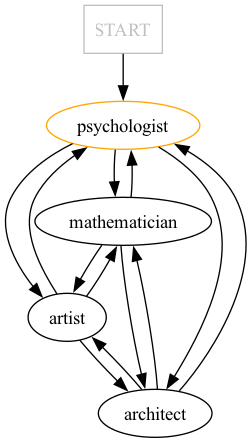

In [18]:
mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist)

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist)

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect)

g = Group(participants=[mathematician_schema, artist_schema, architect_schema, psychologist_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [19]:
res = await g.discussion("what is beauty",next_speaker_select_mode="order",max_turns=5,verbose=True,thread_id="0",user_in_loop=False)


[psychologist] 

 Beauty is often seen as something that makes us feel good or inspires us. It can be found in art, nature, people, and even ideas. What one person finds beautiful, another might not, which shows that beauty is really subjective and based on individual taste and feelings. Basically, it's about what resonates with us in a positive way, whether it's a stunning sunset, a heartfelt song, or a warm smile.

-> handoff from psychologist to mathematician (order mode)

[mathematician] 

 From a mathematician's perspective, we might think of beauty as a kind of symmetry, harmony, or balance found in equations, patterns, or geometrical shapes. Just as beauty can be subjective in art and nature, in mathematics, we often find beauty in elegant proofs, simple solutions, or the unexpected connections between different areas of math.

So, integrating the thoughts of others: beauty can be seen as an aesthetic experience that resonates with us, both in the arts and in mathematics. My ow

In [27]:
res = await g.discussion("what is beauty",next_speaker_select_mode="auto",max_turns=5,verbose=True,thread_id="42",user_in_loop=True)


[architect] 

 Beauty is really all about what makes something pleasing or attractive to our senses. It's subjective, meaning that what one person finds beautiful, another might not. It can be in nature, art, architecture, or even in everyday life. Often, it includes qualities like harmony, balance, and color. Ultimately, beauty is about how something makes us feel—bringing joy, peace, or even inspiration. What do you find beautiful?


[user] 

  In mathematics, beauty often manifests in simplicity, elegance, and surprising connections between concepts.

-> handoff from architect to mathematician (auto mode)

[mathematician] 

 In mathematics, beauty indeed resonates with both simplicity and elegance. It's often found in the way complex problems can be solved with straightforward solutions or in the harmony of a well-structured proof. Beauty in math can also emerge from unexpected relationships between seemingly unrelated concepts, revealing deeper truths about the world.

For example

In [28]:
async def async_chat_demo():
    prompts = ["what is art?","how to learn math?","what is psychology?","what is architecture?"]
    thread_ids = ["1","2","3","4"]

    # Create a list to store the results of asynchronous calls
    # results = []

    # Asynchronously call the function for each prompt
    tasks = [g.chat(prompt,next_speaker_select_mode="auto",verbose=False,thread_id=thread_id) for prompt,thread_id in zip(prompts,thread_ids)]

    # Gather and run the tasks concurrently
    # results = await asyncio.gather(*tasks)

    for answer in asyncio.as_completed(tasks):
        print(await answer)

await async_chat_demo()

[{'role': 'assistant', 'content': "Art is basically any way we express ourselves creatively. It can be painting, music, dance, writing, or even cooking. It’s about conveying feelings, thoughts, or ideas and connecting with others. Some art makes us think, some makes us feel, and some just looks really cool. Everyone has their own taste, and that's what makes it so diverse and exciting!", 'sender': 'artist'}]
[{'role': 'assistant', 'content': 'Psychology is the study of the mind and behavior. It looks at how we think, feel, and act, both individually and in groups. Psychologists try to understand things like emotions, motivations, and how our past experiences shape us. They use this knowledge to help people improve their mental health, relationships, and overall well-being. In simple terms, it’s about understanding what makes us tick and helping us navigate life better.', 'sender': 'psychologist'}]
[{'role': 'assistant', 'content': 'Architecture is basically the art and science of desig

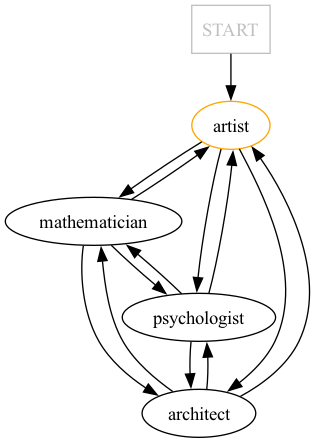

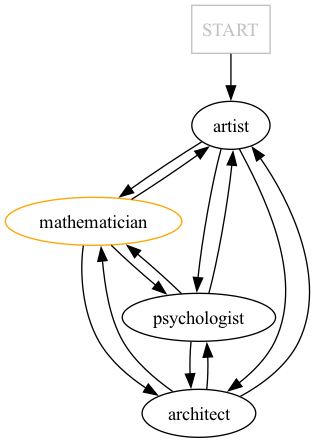

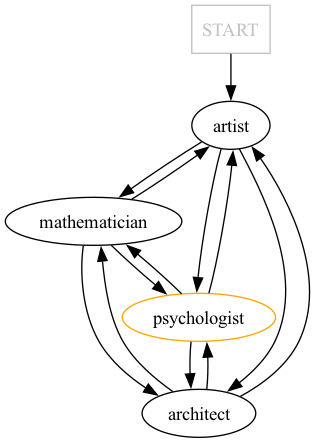

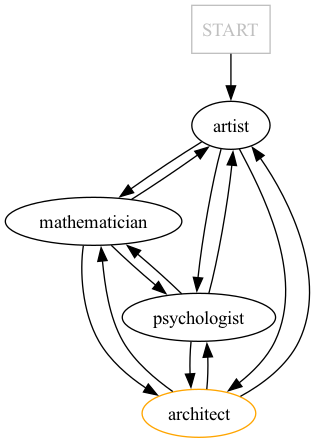

In [29]:
display(Image(g.draw_relations(thread_id="1")))
display(Image(g.draw_relations(thread_id="2")))
display(Image(g.draw_relations(thread_id="3")))
display(Image(g.draw_relations(thread_id="4")))

### CUSTOM STRUCTURE

Group Structure:  CUSTOM


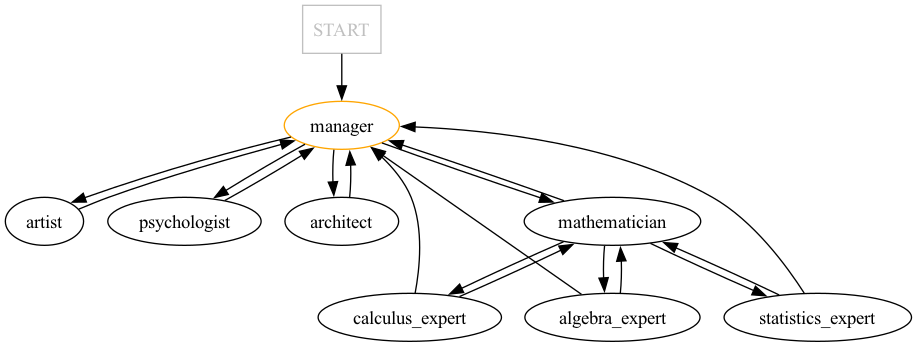

In [30]:
manager = iAgent(name="manager", description="You are a manager,determine which agent to transfer to")

mathematician = iAgent(name="mathematician", description="You are a mathmatician,reply use daily language")
artist = iAgent(name="artist", description="You are an artist,reply use daily language")
architect = iAgent(name="architect", description="You are an architect,reply use daily language")
psychologist = iAgent(name="psychologist", description="You are a psychologist,reply use daily language")

calculus_expert = iAgent(name="calculus_expert", description="You are a calculus expert,reply use daily language")
algebra_expert = iAgent(name="algebra_expert", description="You are an algebra expert,reply use daily language")
statistics_expert = iAgent(name="statistics_expert", description="You are a statistics expert,reply use daily language")

manager_schema = AgentSchema(name="manager",
                            transfer_to_me_description="Call me if you do not know which agent to transfer to.",
                            agent=manager,
                            relations=["mathematician", "artist", "psychologist", "architect"],
                            as_entry=True)

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            agent=artist,
                            relations=["manager"])

psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology.",
                            agent=psychologist,
                            relations=["manager"])

architect_schema = AgentSchema(name="architect",
                            transfer_to_me_description="Call me if you have any questions about architecture.",
                            agent=architect,
                            relations=["manager"])

mathematician_schema = AgentSchema(name="mathematician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            agent=mathematician,
                            relations=["calculus_expert", "algebra_expert", "statistics_expert","manager"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            agent=calculus_expert,
                            relations=["mathematician","manager"])

algebra_expert_schema = AgentSchema(name="algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about algebra.",
                            agent=algebra_expert,
                            relations=["mathematician","manager"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            agent=statistics_expert,
                            relations=["mathematician","manager"])


g = Group(participants=[manager_schema, 
                        artist_schema, psychologist_schema, architect_schema, mathematician_schema, 
                        calculus_expert_schema, algebra_expert_schema, statistics_expert_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))


-> handoff from manager to mathematician (auto mode)

-> handoff from mathematician to statistics_expert (auto mode)


[statistics_expert] 

 Sure! Statistics is all about collecting, analyzing, interpreting, and presenting data. Think of it as a way to make sense of numbers and information so we can understand patterns, trends, and relationships in the world around us.

Let’s break it down:

1. **Collecting Data:** This is about gathering information. For example, you might survey people to find out their favorite ice cream flavors or record temperatures over a week.

2. **Analyzing Data:** Once you have the data, you look for patterns or insights. You could calculate averages, look for trends over time (like how ice cream sales change in summer), or see how different groups compare (like how people in different age groups prefer different flavors).

3. **Interpreting Data:** This is where you take what you've analyzed and figure out what it means. For instance, if you find out that 

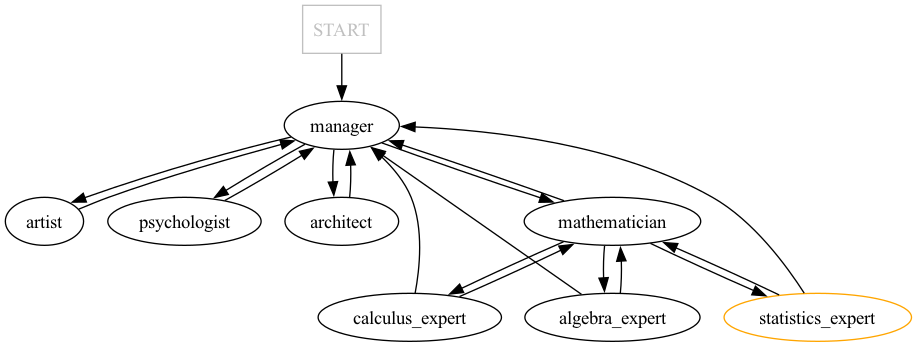

In [31]:
response = await g.chat("expalin the concept of statistics",verbose=True,thread_id="0")
display(Image(g.draw_relations(thread_id="0")))


-> handoff from statistics_expert to manager (auto mode)

-> handoff from manager to psychologist (auto mode)


[psychologist] 

 I’m really sorry to hear that. It’s okay to feel sad sometimes. Do you want to talk about what’s been going on? Sometimes sharing can help a bit.


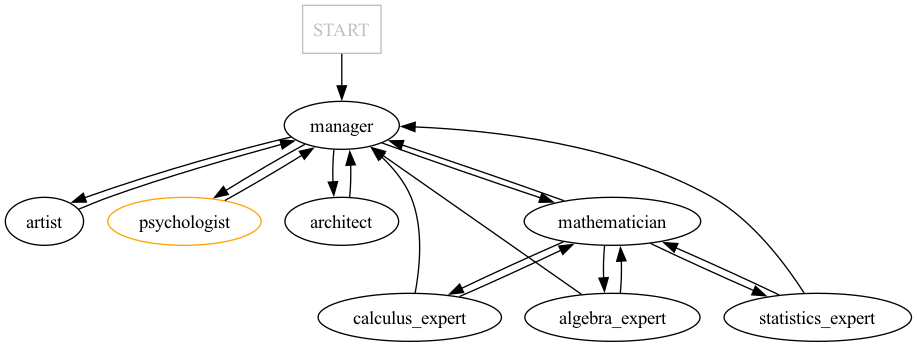

In [32]:
response =  await g.chat("I feel sad",verbose=True,thread_id="0")
display(Image(g.draw_relations(thread_id="0")))

### SEQUENCE STRUCTURE

Group Structure:  SEQUENCE


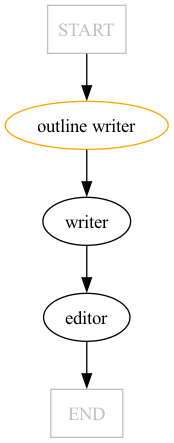

In [33]:
outline_agent = iAgent(name="outline writer", description="You are an outline writer who are good at organizing ideas")
writer = iAgent(name="writer", description="You are a writer who are good at writing drafts")
editor = iAgent(name="editor", description="You are an editor who are good at editing articles and making them more readable")

outline_writer_schema = AgentSchema(name="outline writer",
                                    transfer_to_me_description="Call me if you need help organizing your ideas.",
                                    agent=outline_agent,
                                    relations=["writer"],
                                    as_entry=True)

writer_schema = AgentSchema(name="writer",
                            transfer_to_me_description="Call me if you need help writing articles.",
                            agent=writer,
                            relations=["editor"])

editor_schema = AgentSchema(name="editor",
                            transfer_to_me_description="Call me if you need help editing articles.",
                            agent=editor,
                            as_exit=True)


g = Group(participants=[outline_writer_schema, writer_schema, editor_schema])

print("Group Structure: ", g.group_structure)

display(Image(g.draw_relations()))

In [34]:
res = await g.task("write a article about the importance of reading books",verbose=True,thread_id="0")



[outline writer] 

 ### The Importance of Reading Books: Unlocking the Door to Knowledge and Imagination

#### Introduction
- Brief overview of the role of books in human civilization.
- Importance of reading in personal and intellectual development.
- Thesis statement: Reading books fosters critical thinking, enhances creativity, fuels empathy, and contributes to overall well-being.

#### 1. Reading Books as a Source of Knowledge
   - **A. Historical Perspective**
     - How books have preserved knowledge throughout history.
     - The transition from oral traditions to written literature.
   - **B. Educational Benefits**
     - Expansion of vocabulary and language skills.
     - Improvement in comprehension and analytical skills.
   - **C. Access to Diverse Perspectives**
     - Exposure to various cultures, philosophies, and ideas.
     - Learning from successful individuals through biographies and memoirs.

#### 2. Enhancing Creativity and Imagination
   - **A. Stimulation of Ima